In [1]:
# import sys
# sys.path.append('..')

In [2]:
!ls ~/data | grep SVHN

SVHN
SVHN_150_SUPERPIXEL
SVHN_200_SUPERPIXEL
SVHN_SUPERPIXEL
SVHN_SUPERPIXEL_200.zip
SVHN_SUPERPIXEL.zip


In [3]:
from utility import load_dataset, load_model_with_ckpt, make_one_graph
import draw_utils

/opt/miniconda3/envs/SPGIE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
import torchvision.transforms as VT

In [5]:
import torch
import torchvision.transforms as VT
from torchvision.datasets import SVHN

ori_dataset = SVHN('~/data/SVHN', split='test')
# dataset = load_dataset('svhn', train=False)
num_superpixel = 75
# num_superpixel = 200
dataset = load_dataset('svhn', num_superpixel=num_superpixel, train=False)

----- Loading test dataset -----
---------- dataset path: /home/dragonchen/data/SVHN_SUPERPIXEL ----------


In [6]:
# --- num_superpixel 75
hidden_dim = 64
# drn_k = 4
ckpt_name = '/home/dragonchen/mlruns/0/986307d08fa14fa0a098fd4c0c857d8f/artifacts/best.pt'
# # drn_k = 6
# ckpt_name = '/home/dragonchen/mlruns/0/a91300e9d9c546aca747580e164e0012/artifacts/best.pt'
# # drn_k = 8
# ckpt_name = '/home/dragonchen/mlruns/0/6837984a95404ca1b97c0242ce736691/artifacts/best.pt'

# --- num_superpixel 200
# hidden_dim = 64
# ckpt_name = '/home/dragonchen/mlruns/0/f8fc6a5c52a24d73a28dd0c895b0ea47/artifacts/best.pt'

aggr = 'add'
pool = 'max'
drn_k = 4

device = torch.device('cpu')
model = load_model_with_ckpt(
    input_dim=dataset.num_features,
    hidden_dim=hidden_dim,
    output_dim=dataset.num_classes,
    drn_k=drn_k, aggr=aggr, pool=pool,
    device=device,
    ckpt_name=ckpt_name,
)

Pooling with max
Using self-loops
There are 2 aggregation layers


In [7]:
import numpy as np
img_idx = 20
img_ori, lbl = ori_dataset[img_idx]
img_ori = torch.from_numpy(np.array(img_ori)) / 255
img_sp, node2map = make_one_graph(
    img_ori, channel_axis=2,
    num_superpixel=num_superpixel,
)
img_sp.y = torch.tensor(lbl)

graph = dataset[img_idx]

In [8]:
# temp = dataset[0]
# temp = img_sp
# print(temp.x.dtype)
# print(temp.edge_index.dtype)
# print(temp.y.dtype)
# print(temp.pos.dtype)

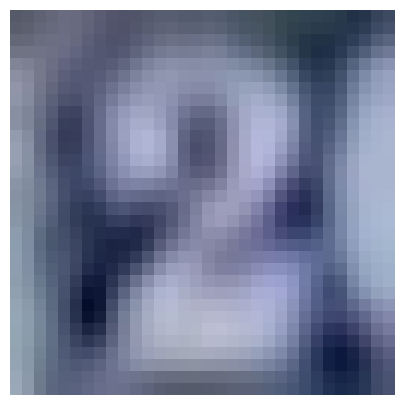

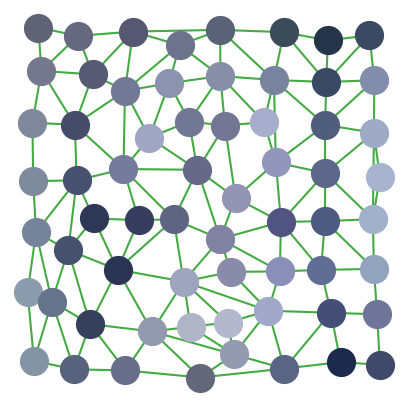

torch.Size([64, 2])


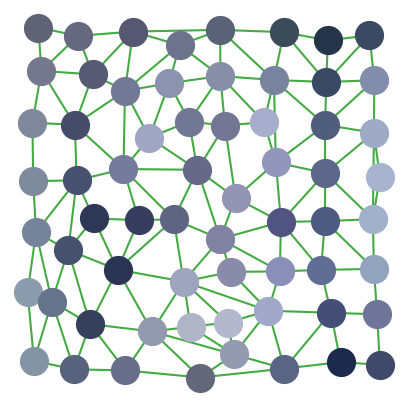

torch.Size([64, 2])


In [9]:
import matplotlib.pyplot as plt

# original
draw_utils.show_original(torch.permute(img_ori, (2, 0, 1)))

# superpixel version
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, img_sp.x[:, 2:],
    img_sp.edge_index,
)
plt.show()
print(img_sp.pos.shape)

# dataset version
draw_utils.draw_superpixel_from_graph(
    graph.pos, graph.x[:, 2:],
    graph.edge_index,
)
print(graph.pos.shape)
plt.show()

In [10]:
img_sp.batch = torch.zeros(img_sp.x.shape[0]).long()
img_sp = img_sp.to(device)

out = model(img_sp).detach().cpu()

print('true', lbl)
print('pred', out.argmax(1).item())

true 2
pred 2


In [11]:
# torch.manual_seed(1340)
for i, c in enumerate(torch.softmax(out, 1).tolist()[0]):
    print(f'{i} {c:.04f}')

0 0.0000
1 0.0000
2 0.9999
3 0.0000
4 0.0000
5 0.0000
6 0.0000
7 0.0000
8 0.0000
9 0.0000


In [12]:
import sys
sys.path.append('..')
from models.drn_train import test
from torch_geometric.loader import DataLoader

test_dev = torch.device('cuda:0')
loader = DataLoader(dataset, batch_size=128, shuffle=False)
acc, _ = test(model.to(test_dev), loader, device=test_dev, mlflow_log=False)
print(f'Got {acc * 100:.2f}% acc on testing set.')
model = model.to(device)

100%|██████████| 204/204 [00:04<00:00, 46.32it/s]

Got 76.99% acc on testing set.


## Start Explaining

In [13]:
from PIL import Image
plt.rcParams['figure.facecolor'] = '#fffafa'
import networkx as nx
from skimage.segmentation import slic, mark_boundaries

In [14]:
from models.jit_drn_model import (
    knn_graph, to_undirected, normalized_cut_2d,
    graclus_cluster,
#     aggr_pool, aggr_pool_x,
    global_pool_aggr
)

In [15]:
from torch_scatter import scatter
from torch_geometric.typing import OptTensor, Optional, Tuple
from torch import Tensor
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool.pool import pool_batch

def _aggr_pool_x(cluster, x, aggr: str, size: Optional[int] = None):
    """Call into scatter with configurable reduction op"""
    return scatter(x, cluster, dim=0, dim_size=size, reduce=aggr)

def global_pool_aggr(x, batch: OptTensor, aggr: str, size: Optional[int] = None):
    """Global pool via passed aggregator: 'mean', 'add', 'max'"""
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if batch is not None:
        size = int(batch.max().item() + 1)
    assert batch is not None
    return scatter(x, batch, dim=0, dim_size=size, reduce=aggr)

# this function is specialized compared to the more general non-jittable version
# in particular edge_attr can be removed since it is always None
def aggr_pool(cluster, x, batch: OptTensor, aggr: str) -> Tuple[Tensor, OptTensor]:
    """jit-friendly version of max/mean/add pool"""
    global node_hist
    print('c1', cluster.shape)
    print(cluster[:20])
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster[:20])
    print('perm', perm.shape)
    print('perm', perm[:10])
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })

    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)
    return x, batch

def aggr_pool_x(cluster, x, batch: OptTensor, aggr: str, size: Optional[int] = None) -> Tuple[Tensor, OptTensor]:
    """*_pool_x with configurable aggr method"""
    global node_hist
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if size is not None and batch is not None:
        batch_size = int(batch.max().item()) + 1
        return _aggr_pool_x(cluster, x, aggr, batch_size * size), None

    print('c1', cluster.shape)
    print(cluster)
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    print('c2', cluster.shape)
    print(cluster)
    print('perm', perm.shape)
    print('perm', perm)
    c2 = cluster.detach().cpu()
    p = perm.detach().cpu()
    node_hist.append({
        'c1': c1,
        'c2': c2,
        'p': p
    })
    
    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)

    return x, batch

start x torch.Size([64, 64])
c1 torch.Size([64])
tensor([ 0,  1,  2,  3,  3,  5,  5,  7,  0,  2,  7, 11, 12, 13, 14, 12, 16, 16,
        14, 19])
c2 torch.Size([64])
tensor([ 0,  1,  2,  3,  3,  4,  4,  5,  0,  2,  5,  6,  7,  8,  9,  7, 10, 10,
         9, 11])
perm torch.Size([36])
perm tensor([ 8,  1,  9,  4,  6, 10, 20, 15, 23, 18])


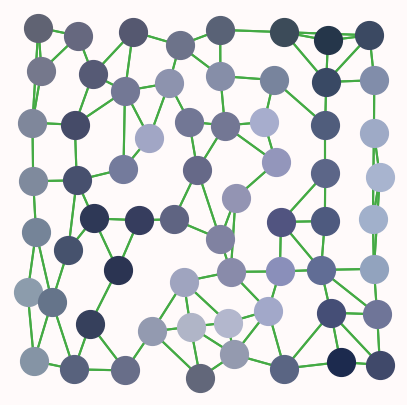

c1 torch.Size([36])
tensor([ 0,  1,  0,  3,  4,  3,  4,  7,  8,  9, 10, 11, 12, 13,  8, 11,  7,  1,
        18, 19, 10, 21, 18, 21, 24, 25, 12, 25, 28, 24, 30, 19, 30, 33, 28, 33])
c2 torch.Size([36])
tensor([ 0,  1,  0,  2,  3,  2,  3,  4,  5,  6,  7,  8,  9, 10,  5,  8,  4,  1,
        11, 12,  7, 13, 11, 13, 14, 15,  9, 15, 16, 14, 17, 12, 17, 18, 16, 18])
perm torch.Size([19])
perm tensor([ 2, 17,  5,  6, 16, 14,  9, 20, 15, 26, 13, 22, 31, 23, 29, 27, 34, 32,
        35])
global x tensor([[19.0147, -3.8219, 14.3192, 19.7281,  7.6842, 54.1415, 71.2139,  8.8436,
         25.4419, 51.6578,  7.6582, 14.6741, 25.4031,  9.3400, 11.8566,  3.4166,
          6.1737,  4.9033, 25.8863,  5.5130,  5.8475, 23.8765, 13.4871, -2.1892,
          9.9491,  2.5486, 30.7128,  1.0804,  7.7687, 51.4345, 10.8215, 15.5266,
          9.8219,  0.5984,  8.5459, 67.7197,  8.0393, 12.1376,  4.9050, 11.4591,
         61.1636, 38.0492, 61.9468, 58.9741,  5.1855, 33.1923, 21.7345, 39.9736,
          3.6778,  2.55

[[-14.921202659606934,
  -10.22653865814209,
  -0.00016950124700088054,
  -9.815818786621094,
  -13.433789253234863,
  -12.015625953674316,
  -14.963411331176758,
  -9.922662734985352,
  -11.082345008850098,
  -12.005573272705078]]

In [16]:
import torch.nn.functional as F

torch.manual_seed(100)

drn = model.drn # get the model layer
x = img_sp.x
batch = img_sp.batch

# draw_superpixel_from_graph(x, gd.edge_index)

x = drn.datanorm * x
x = drn.inputnet(x)

nAgg = len(drn.agg_layers)

node_hist = []
print(f'start x', x.shape)
node_hist.append({'x': x.detach().cpu()})
for i, edgeconv in enumerate(drn.agg_layers):
    knn = knn_graph(x, drn.k, batch, loop=drn.loop, flow=edgeconv.flow)
#     print(f'i {i} knn', knn.shape)
    edge_index = to_undirected(knn)
#     print(x.T)
#     plot_x(x)
    x = edgeconv(x, edge_index)
#     print(x.T)
#     plot_x(x)
    
#     print(f'i {i} edge conv', x.shape)

    weight = normalized_cut_2d(edge_index, x)
    cluster = graclus_cluster(edge_index[0], edge_index[1], weight, x.size(0))
#     print(f'i {i} cluster', cluster.shape)

    if i == nAgg - 1:
        x, batch = aggr_pool_x(cluster, x, batch, drn.aggr_type)
    else:
        x, batch = aggr_pool(cluster, x, batch, drn.aggr_type)
    
    # extract history node
#     hist = cluster.tolist()
# #     print('h', hist)
#     node_hist.append(torch.tensor(hist))
    xx = img_sp.x.cpu()
    ee = edge_index.cpu()
#     print('h', hist)
#     print('ee', ee)
    node_hist.append({'x': x.detach().cpu()})
    
    if i == 0:
        draw_utils.draw_superpixel_from_graph(
            xx[:, :2], xx[:, 2:], ee
        )


# print('b', batch)
x = global_pool_aggr(x, batch, drn.aggr_type)
print('global x', x)
node_hist.append({'global_x': x.detach().cpu()})

# print(f'global x', x.shape)

out = drn.output(x).squeeze(-1)
out = F.log_softmax(out, dim=1)
out.tolist()

In [17]:
# print([n.keys() for n in node_hist])
# for n in node_hist:
#     print('-----layer-----')
#     for k in n:
#         print(k, n[k].shape)

In [18]:
# from global x to layer2
from collections import defaultdict
counter = defaultdict(int)
basenode_values = defaultdict(list)
xx2 = node_hist[-2]['x']

gx = node_hist[-1]['global_x'].squeeze()
for i, g in enumerate(gx.tolist()):
    if g > 0:
        xx2k = xx2[:, i].tolist().index(g)
        counter[xx2k] += 1
        basenode_values[xx2k].append(g)
print('counter', counter)
print('basenode_imp', basenode_values)

basenode_imp = {}
for k, v in basenode_values.items():
    print('k', k, end=' ')
    avg = sum(v) / len(v)
    print('avg', avg)
    basenode_imp[k] = avg

counter defaultdict(<class 'int'>, {3: 2, 18: 8, 15: 7, 13: 12, 12: 2, 8: 11, 11: 6, 6: 2, 7: 2, 5: 4, 4: 1, 0: 3, 2: 1, 14: 1})
basenode_imp defaultdict(<class 'list'>, {3: [19.014711380004883, 25.88626480102539], 18: [14.319188117980957, 7.684157371520996, 25.40305519104004, 3.416609287261963, 2.5486233234405518, 8.545896530151367, 11.459135055541992, 3.810765504837036], 15: [19.728105545043945, 71.21391296386719, 5.847519874572754, 9.94908332824707, 5.1855034828186035, 1.8208765983581543, 7.34700870513916], 13: [54.14149475097656, 51.65778732299805, 5.513018608093262, 1.080380916595459, 51.43450164794922, 10.821483612060547, 67.71968078613281, 38.04924392700195, 2.5563950538635254, 5.665130615234375, 29.171878814697266, 24.24752426147461], 12: [8.843608856201172, 23.87648582458496], 8: [25.441905975341797, 14.674124717712402, 11.856597900390625, 13.487096786499023, 30.712778091430664, 9.821854591369629, 33.192264556884766, 39.97362518310547, 33.38528823852539, 10.549118995666504, 25

In [19]:
# pick those nodes be refered multiple times
l1 = node_hist[1]
l2 = node_hist[3]

final_nodes = [n for n in counter if counter[n] > 1] # there !
final_nodes

[3, 18, 15, 13, 12, 8, 11, 6, 7, 5, 0]

In [20]:
# base on nodes do softmax on basenode_imp
temp_keys = [k for k in basenode_imp if k in final_nodes]
print('keys', temp_keys)
temp_values = [v for k, v in basenode_imp.items() if k in final_nodes]
print('values', temp_values)

x = temp_values

# # softmax
# temp_values = torch.softmax(torch.tensor(x), dim=0).tolist()
# print('new', temp_values)

# min-max
min_v = np.min(x)
max_v = np.max(x)
temp_values = (x - min_v) / (max_v - min_v)
print('new', temp_values)

# put it back
basenode_imp = dict(zip(temp_keys, temp_values))

keys [3, 18, 15, 13, 12, 8, 11, 6, 7, 5, 0]
values [22.450488090515137, 9.648428797721863, 17.298858642578125, 28.504876693089802, 16.360047340393066, 22.56625895066695, 35.74923396110535, 4.969188094139099, 8.520417928695679, 7.969513118267059, 35.19545682271322]
new [0.56794262 0.15202189 0.40057349 0.76464112 0.37007285 0.57170385
 1.         0.         0.11537442 0.0974763  0.98200857]


In [21]:
basenode_track = {} # record basenode mapping

nodes_l2 = []
for n in final_nodes:
    idx = l2['p'][n].item() # put node-num get cluster idx
    print(idx)
    c = l2['c2'][idx].item() # extract original node-num from cluster idx
    print('c', c)
    nodes = torch.arange(len(l2['c2']))[l2['c2'] == c].tolist()
    print('nodes', nodes)
    
    for cn in nodes: # child node
        basenode_track[cn] = c
    
    nodes_l2 += nodes
nodes_l2

6
c 3
nodes [4, 6]
35
c 18
nodes [33, 35]
27
c 15
nodes [25, 27]
23
c 13
nodes [21, 23]
31
c 12
nodes [19, 31]
15
c 8
nodes [11, 15]
22
c 11
nodes [18, 22]
9
c 6
nodes [9]
20
c 7
nodes [10, 20]
14
c 5
nodes [8, 14]
2
c 0
nodes [0, 2]


[4, 6, 33, 35, 25, 27, 21, 23, 19, 31, 11, 15, 18, 22, 9, 10, 20, 8, 14, 0, 2]

In [22]:
temp_track = {}

nodes_l1 = []
for n in nodes_l2:
    idx = l1['p'][n].item() # put node-num get cluster idx
    print(idx)
    c = l1['c2'][idx].item() # extract original node-num from cluster idx
    print('c', c)
    nodes = torch.arange(len(l1['c2']))[l1['c2'] == c].tolist()
    print('nodes', nodes)
    
    for cn in nodes: # child node
        temp_track[cn] = basenode_track[c] # extrac parent's basenode into child node
    
    nodes_l1 += nodes
basenode_track = temp_track
nodes_l1

6
c 4
nodes [5, 6]
20
c 6
nodes [11, 20]
59
c 33
nodes [58, 59]
63
c 35
nodes [62, 63]
54
c 25
nodes [44, 54]
52
c 27
nodes [48, 52]
34
c 21
nodes [34]
41
c 23
nodes [38, 41]
42
c 19
nodes [32, 42]
55
c 31
nodes [55]
24
c 11
nodes [19, 24]
39
c 15
nodes [26, 39]
30
c 18
nodes [30]
46
c 22
nodes [35, 46]
18
c 9
nodes [14, 18]
17
c 10
nodes [16, 17]
40
c 20
nodes [33, 40]
23
c 8
nodes [13, 23]
29
c 14
nodes [25, 29]
8
c 0
nodes [0, 8]
9
c 2
nodes [2, 9]


[5,
 6,
 11,
 20,
 58,
 59,
 62,
 63,
 44,
 54,
 48,
 52,
 34,
 38,
 41,
 32,
 42,
 55,
 19,
 24,
 26,
 39,
 30,
 35,
 46,
 14,
 18,
 16,
 17,
 33,
 40,
 13,
 23,
 25,
 29,
 0,
 8,
 2,
 9]

## Draw

In [23]:
import random
color_set = {
    v: [random.randint(0, 255) for _ in range(3)]
    for _, v in basenode_track.items()
}

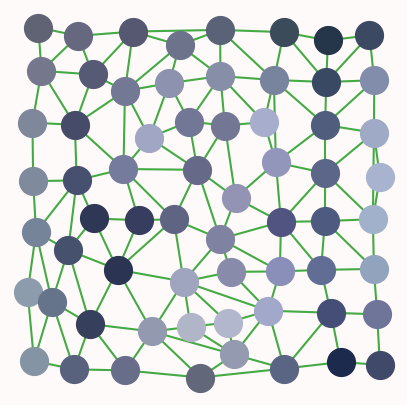

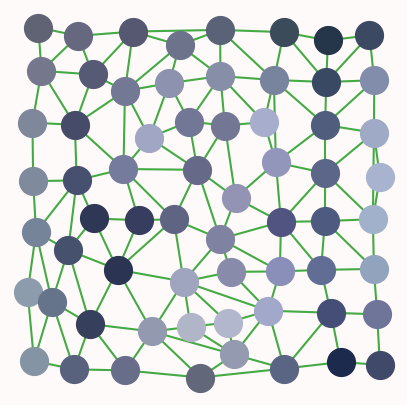

In [24]:
# use old function print
import numpy as np
pos = img_sp.x[:, :2].cpu().numpy()
# pos = np.flip(pos, 1)
rgb = img_sp.x[:, 2:].cpu().numpy().astype(int)
draw_utils.draw_superpixel_from_graph(
    pos, rgb, img_sp.edge_index, multi_graph=False,
)

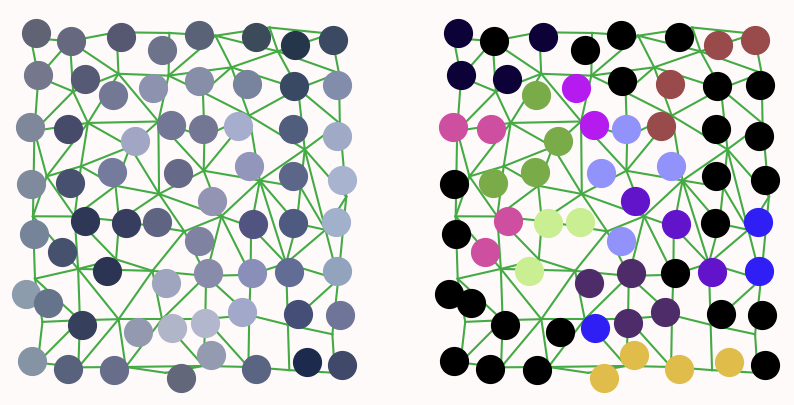

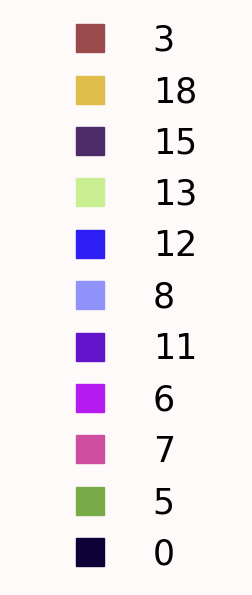

In [25]:
# old function print original, forus and basenode highlight
img = img_sp
pos = img.x[:, :2].cpu().numpy()
# pos = np.flip(pos, 1)
rgb = img.x[:, 2:].cpu().numpy().astype(int)

# # single colour
# imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
# for n in nodes_l1:
#     imp[n][1] = 150

# basenode track
imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
    imp[n] = color_set[basenode_track[n]]

draw_utils.draw_superpixel_from_graph(
    pos, [rgb, imp], img.edge_index, multi_graph=True,
)

# color_set
plt.figure(figsize=(3, 3))
colors = ['#{:02x}{:02x}{:02x}'.format(*c) for n, c in color_set.items()]
f = lambda m,c: plt.plot([],[],marker=m, markersize=20, color=c, ls="none")[0]
handles = [f("s", c) for c in colors]
labels = [n for n, _ in color_set.items()]
legend = plt.legend(
    handles, labels,
    loc='center', framealpha=1, frameon=False,
    fontsize=25,
)
plt.axis('off')
# plt.show()
plt.savefig('demo1.svg')

true 2
pred 2


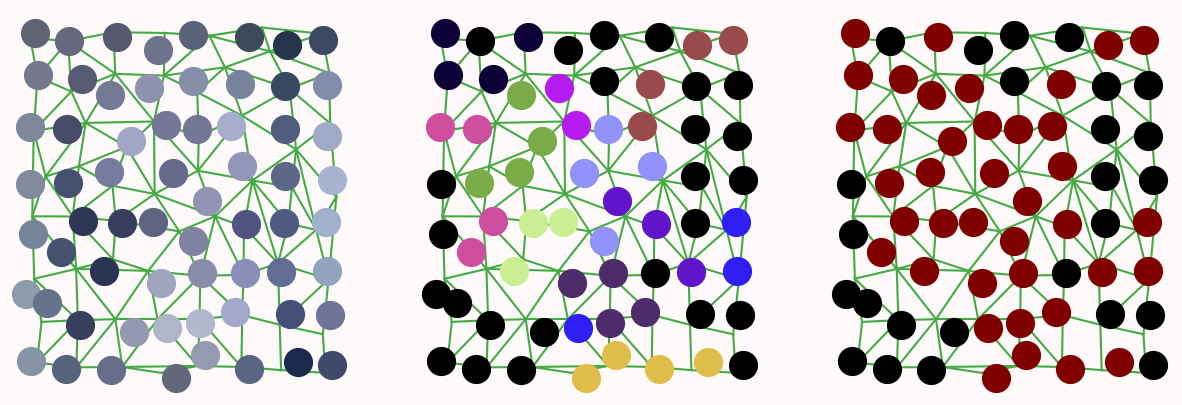

temp (32, 32, 3)


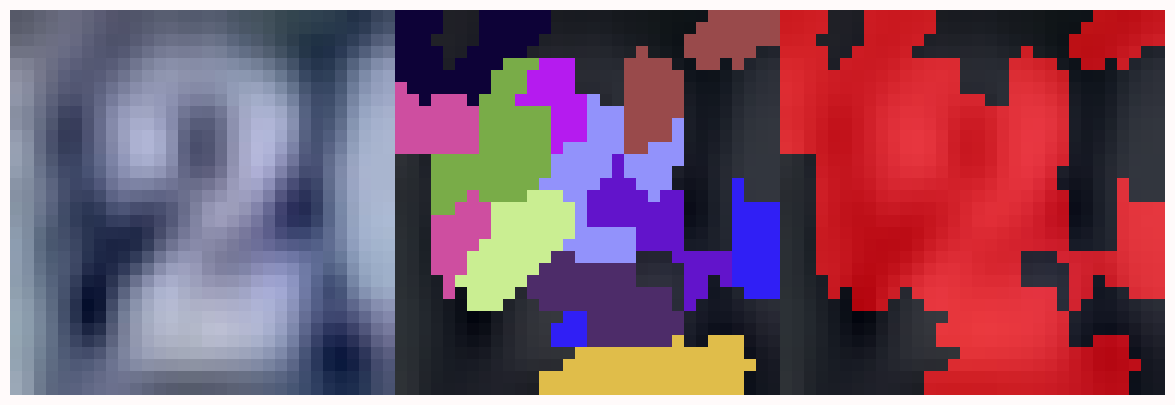

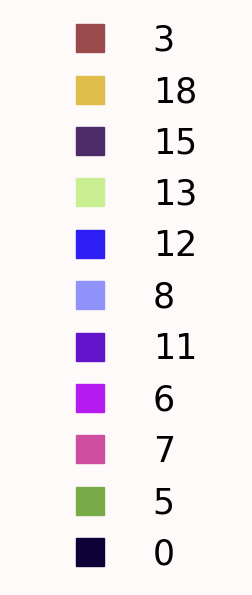

In [26]:
print('true', lbl)
print('pred', out.argmax(1).item())

# print rgb, basenode and imp
pos = img.x[:, :2].cpu().numpy()
# pos = np.flip(pos, 1)
rgb = img.x[:, 2:].cpu().numpy().astype(int)

# # single colour
# imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
# for n in nodes_l1:
#     imp[n][1] = 150

# basenode track
imp = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
    imp[n] = color_set[basenode_track[n]]

# basenode imp
imp2 = [[0, 0, 0] for _ in range(rgb.shape[0])]
for n in nodes_l1:
#     c = int(basenode_imp[basenode_track[n]] * 255)
#     imp2[n][1] = c
    imp2[n][0] = 128

draw_utils.draw_superpixel_from_graph(
    pos, [rgb, imp, imp2], img.edge_index, multi_graph=True,
)
# util.draw_superpixel_from_graph(pos, [rgb, imp2], img, multi_graph=True)


img_temp1 = img_ori.numpy().copy()
img_temp1 = img_temp1 * 0.3
img_temp2 = img_temp1.copy()

print('temp', img_temp1.shape)
for n in nodes_l1:
    m = node2map[n]
    
    replace_color = np.array(color_set[basenode_track[n]])
    img_temp1[m, :] = replace_color / 255
    img_temp2[m, 0] += 0.7

img_out = np.concatenate([img_ori, img_temp1, img_temp2], axis=1)
# print('out', img_out.shape)
draw_utils.show_original(np.transpose(img_out, (2, 0, 1)), width=15)


# color_set
plt.figure(figsize=(3, 3))
colors = ['#{:02x}{:02x}{:02x}'.format(*c) for n, c in color_set.items()]
f = lambda m,c: plt.plot([],[],marker=m, markersize=20, color=c, ls="none")[0]
handles = [f("s", c) for c in colors]
labels = [n for n, _ in color_set.items()]
legend = plt.legend(
    handles, labels,
    loc='center', framealpha=1, frameon=False,
    fontsize=25,
)
plt.axis('off')
plt.show()